In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
import os
os.listdir('/content')

['.config', 'sample_data']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
pip install rarfile

In [ ]:
import rarfile

rar_path = '/content/drive/My Drive/archive.rar'
extract_path = '/content/'

with rarfile.RarFile(rar_path, 'r') as rar_ref:
    rar_ref.extractall(extract_path)

In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/archive.zip'

extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
BASE_DIR = '/content'
WORKING_DIR = '/content'

In [ ]:
model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# Define the features dictionary to store extracted features
features = {}

# Define the directory containing the images
directory = os.path.join(BASE_DIR, 'Images')

# Iterate through each image in the directory
for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))

    # Convert image pixels to numpy array
    image = img_to_array(image)

    # Reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess image for VGG
    image = preprocess_input(image)

    # Extract features
    feature = model.predict(image, verbose=0)

    # Get image ID
    image_id = img_name.split('.')[0]

    # Store feature
    features[image_id] = feature

  0%|          | 0/992 [00:00<?, ?it/s]

In [ ]:
# Define the path to save the pickle file
pickle_file_path = os.path.join(WORKING_DIR, 'features.pkl')

# Store features in pickle
with open(pickle_file_path, 'wb') as f:
    pickle.dump(features, f)

In [ ]:
# Define the path to load the pickle file
pickle_file_path = os.path.join(WORKING_DIR, 'features.pkl')

# Load features from pickle
with open(pickle_file_path, 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:

# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

In [ ]:
# create mapping of image to captions
mapping = {}

# Iterate through each image in the features dictionary
for image_id in tqdm(features.keys()):
    # Initialize an empty list to store captions for the current image
    mapping[image_id] = []

# Process lines from the captions document
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')

    # Check if the line is valid (contains at least two tokens)
    if len(tokens) < 2:
        continue

    # Extract the image ID
    image_id = tokens[0].split('.')[0]

    # Check if the image ID is present in the features dictionary
    if image_id in mapping:
        # Convert caption tokens to a string
        caption = " ".join(tokens[1:])
        # Append the caption to the list of captions for the current image
        mapping[image_id].append(caption)


  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

992

In [ ]:
# Initialize a variable to store the total number of captions
total_captions = 0

# Iterate through each image ID in the mapping dictionary
for image_id, captions_list in mapping.items():
    # Increment the total number of captions by the length of the captions list
    total_captions += len(captions_list)

# Print the total number of captions
print("Total number of captions:", total_captions)

Total number of captions: 4960


In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['10815824_2997e03d76']

['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .',
 'A girl and her horse stand by a fire .',
 "A girl holding a horse 's lead behind a fire .",
 '"A man   and girl and two horses are near a contained fire ."',
 'Two people and two horses watching a fire .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['33108590_d685bfe51c']

['startseq young couple inspect merchandise from street vendor endseq',
 'startseq people are gathering around table of food and outside taxi wisks by endseq',
 'startseq three people prepare table full of food with police car in the background endseq',
 'startseq two people look at street vendor endseq',
 'startseq two women and man at food counter in dim lights endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

4960

In [ ]:
all_captions[:10]

['startseq two staffordshire terriers race through field in the woods endseq',
 'startseq two brown dogs running in grassy field endseq',
 'startseq two dogs running in the woods endseq',
 'startseq two dogs run through grassy patch that is surrounded by trees endseq',
 'startseq two tan dogs run along field at the edge of woods endseq',
 'startseq brown dog carries something in his mouth while walking through snow endseq',
 'startseq dark-colored dog walking across snow with something in its mouth endseq',
 'startseq dog carries an object in the snow endseq',
 'startseq dog walks through the snow while blindfolded carrying something in his mouth endseq',
 'startseq the brown dog has an object in his mouth endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

3126

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

29

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:

# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

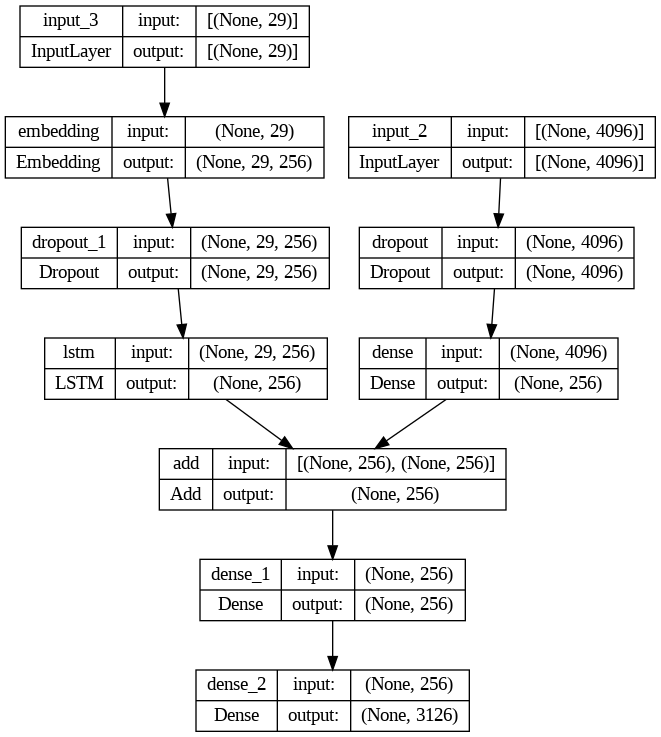

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

27/27 [==============================] - 110s 4s/step - loss: 1.9956


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/100 [00:00<?, ?it/s]

BLEU-1: 0.542056
BLEU-2: 0.324127


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq backpacker in the mountains using his hiking stick to point at glacier endseq
startseq backpacker points to the snow-capped mountains as he stands on rocky plain endseq
startseq hiker is pointing towards the mountains endseq
startseq hiker poses for picture in front of stunning mountains and clouds endseq
startseq man with green pack using his pole to point to snowcapped mountains endseq
--------------------Predicted--------------------
startseq backpacker using hiking up to point to point to mountains endseq


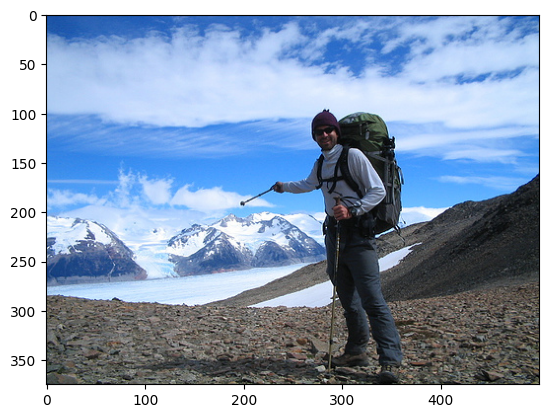

In [ ]:
generate_caption("54501196_a9ac9d66f2.jpg")

---------------------Actual---------------------
startseq lone climber on snowcapped mountain with several huge mountains in the background endseq
startseq man is standing looking at the path ahead while hiking in mountain range endseq
startseq man on top of mountain looks at the mountains surrounding him endseq
startseq person with backpack stands on snowy mountain endseq
startseq sole mountain climber stands atop snowy peak looking left endseq
--------------------Predicted--------------------
startseq man is standing on snowy mountain endseq


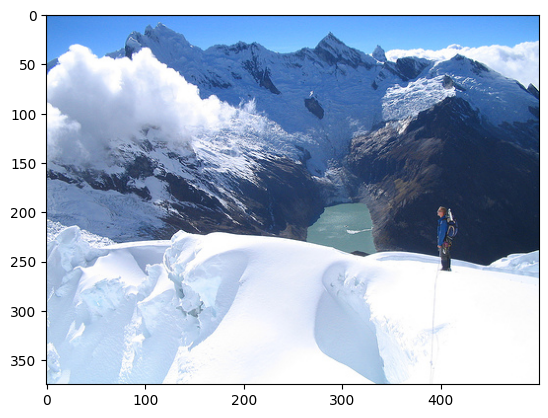

In [ ]:
generate_caption("56494233_1824005879.jpg")

---------------------Actual---------------------
startseq girl is stretched out in shallow water endseq
startseq girl wearing red and multi-colored bikini is laying on her back in shallow water endseq
startseq little girl in red swimsuit is laying on her back in shallow water endseq
startseq "a young girl is lying in the sand while ocean water is surrounding her ." endseq
startseq girl wearing bikini lying on her back in shallow pool of clear blue water endseq
--------------------Predicted--------------------
startseq girl is laying on shallow water endseq


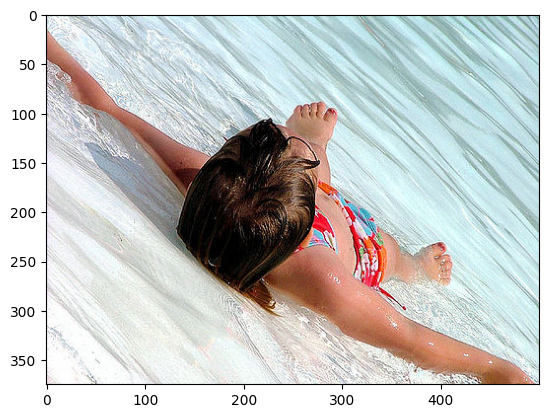

In [ ]:
generate_caption("667626_18933d713e.jpg")

In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [ ]:
image_path = '/content/Images/101654506_8eb26cfb60.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq white dog runs through the snow endseq'